# DBSCAN 

In [24]:
import time
import warnings
import math
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn import cluster

np.random.seed(0)

## Dataset for testing

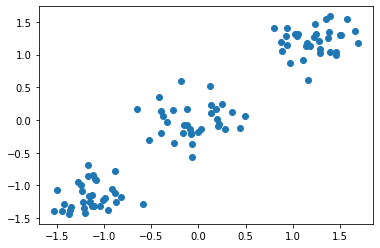

In [25]:
data, y = make_blobs(n_samples=100, centers = [(-5, -5), (0, 0), (5, 5)], cluster_std=1, n_features=2, random_state=5)
data = StandardScaler().fit_transform(data)

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1])
# for i, txt in enumerate(range(len(data))):
#     ax.annotate(i, (data[i,0], data[i,1]), size=15)
plt.show()

## Initial variables

In [26]:
NOT_VISITED = 0
VISTED = 1
CLUSTERED = 2

n = data.shape[0]
cluster = np.array([0] * n)
state = np.array([NOT_VISITED] * n)
cluster_id = 1

## Similarity measure: euclidean distance

In [27]:
def euclidean_distance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return np.sqrt(distance)

## Get reachable neighbors

In [28]:
def get_neighbors(data, current_index, epsilon):
    neighbor_indices = []
    for neighbor_index, neighbor in enumerate(data):
        if distance.euclidean(neighbor, data[current_index]) <= epsilon:
            neighbor_indices.append(neighbor_index) 
    return neighbor_indices

## Look for a cluster

In [29]:
def search(current_index, cluster_id, epsilon, minPts):
    neighbor_indices = get_neighbors(data, current_index, epsilon)
    if len(neighbor_indices) >= minPts:
        state[current_index] = CLUSTERED
        cluster[current_index] = cluster_id
        for neighbor_index in neighbor_indices:
            if state[neighbor_index] == NOT_VISITED:
                state[neighbor_index] = CLUSTERED
                cluster[neighbor_index] = cluster_id
                search(neighbor_index, cluster_id, epsilon, minPts)
    else:
        state[current_index] = VISTED

## Clusterization test

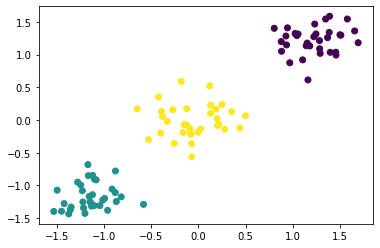

In [30]:
epsilon = 0.5
minPts = 7

while NOT_VISITED in state:
    not_visited_ids = np.where(state==NOT_VISITED)[0]
    search(not_visited_ids[0], cluster_id, epsilon, minPts)
    cluster_id += 1
    
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=cluster)
plt.show()

# reset to initial state
cluster = np.array([0] * n)
state = np.array([NOT_VISITED] * n)

## All within one function

In [31]:
def dbscan(data, epsilon, minPts):
    
    NOT_VISITED = 0
    VISTED = 1
    CLUSTERED = 2

    n = data.shape[0]
    cluster = np.array([0] * n)
    state = np.array([NOT_VISITED] * n)
    cluster_id = 1
    
    def euclidean_distance(x1, x2):
        distance = 0
        for i in range(len(x1)):
            distance += pow((x1[i] - x2[i]), 2)
        return math.sqrt(distance)
    
    def get_neighbors(data, current_index, epsilon):
        neighbor_indices = []
        for neighbor_index, neighbor in enumerate(data):
            if distance.euclidean(neighbor, data[current_index]) <= epsilon:
                neighbor_indices.append(neighbor_index) 
        return neighbor_indices

    def search(current_index, cluster_id, epsilon, minPts):
        neighbor_indices = get_neighbors(data, current_index, epsilon)
        if len(neighbor_indices) >= minPts:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in neighbor_indices:
                if state[neighbor_index] == NOT_VISITED:
                    state[neighbor_index] = CLUSTERED
                    cluster[neighbor_index] = cluster_id
                    search(neighbor_index, cluster_id, epsilon, minPts)
        else:
            state[current_index] = VISTED

    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0]
        search(not_visited_ids[0], cluster_id, epsilon, minPts)
        cluster_id += 1
    
    return cluster

## DBSCRN wrapped into a class for convenient use

In [32]:
class DBSCAN():

    def __init__(self, epsilon, minPts):
        self.epsilon = epsilon
        self.minPts = minPts

    def fit_transform(self, X):
        result = dbscan(X, self.epsilon, self.minPts)
        return result

# DBSCRN

## Dataset for testing

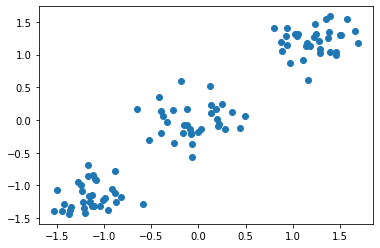

In [33]:
data, y = make_blobs(n_samples=100, centers = [(-5, -5), (0, 0), (5, 5)], cluster_std=1, n_features=2, random_state=5)
data = StandardScaler().fit_transform(data)

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1])
# for i, txt in enumerate(range(len(data))):
#     ax.annotate(i, (data[i,0], data[i,1]), size=15)
plt.show()

## Initial variables

In [34]:
n = data.shape[0] # number of samples

# possible states for each sample 
NOT_VISITED = 0
VISTED = 1
CLUSTERED = 2
state = np.array([NOT_VISITED] * n) # if given point is visited, not visited or clustered

cluster = np.array([0] * n) # clasters ID
cluster_id = 1 # first cluster ID

all_point_indices = list(range(len(data))) # inidces of all points

## Similarity measure: euclidean distance

In [35]:
def euclidean_distance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return np.sqrt(distance)

## KNN

In [36]:
def get_knn(current_index, neighbor_indices, k):
    neighbor_indices.remove(current_index)
    neighbor_distances = []
    for neighbor_index in neighbor_indices:
        distance = euclidean_distance(data[neighbor_index], data[current_index])
        neighbor_distances.append(distance) 
    sort_indices = np.argsort(neighbor_distances)
    neighbor_indices = np.array(neighbor_indices)
    return neighbor_indices[sort_indices][:k].tolist()

## RNN

In [37]:
def get_rnn(point_knn, current_index):
    rnn = []
    for neighbor in point_knn[current_index]:
        if current_index in point_knn[neighbor]:
            rnn.append(neighbor)
    return rnn
    
def get_pointwise_rnn(point_indices, k):
    point_rnn = {}
    point_knn = {}
    for current_index in point_indices:
        knn = get_knn(current_index, point_indices[:], k)
        point_knn[current_index] = knn
    for current_index in point_indices:
        rnn = get_rnn(point_knn, current_index)
        point_rnn[current_index] = rnn
    return point_rnn

## Look for a cluster

In [38]:
def search(current_index, k, point_rnn):
    if len(point_rnn[current_index]) < k:
            state[current_index] = VISTED
    else:
        state[current_index] = CLUSTERED
        cluster[current_index] = cluster_id
        for neighbor_index in point_rnn[current_index]:
            if state[neighbor_index] == NOT_VISITED:
                state[neighbor_index] = CLUSTERED
                cluster[neighbor_index] = cluster_id
                search(neighbor_index, k, point_rnn)

## Clusterization test

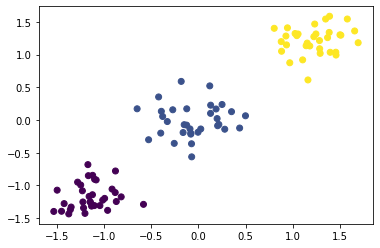

In [39]:
point_rnn = get_pointwise_rnn(all_point_indices, k)
    
# Look for a cluster within not visited
while NOT_VISITED in state:
    not_visited_ids = np.where(state==NOT_VISITED)[0]
    search(not_visited_ids[0], k, point_rnn)
    cluster_id += 1

# Assign rest points to nearest cluster
while VISTED in state:
    visited_id = np.where(state==VISTED)[0][0]
    knn = get_knn(visited_id, all_point_indices[:], k)
    cluster[visited_id] = Counter(cluster[knn]).most_common(1)[0][0] 
    state[visited_id] = CLUSTERED
    
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=cluster)
plt.show()

# reset to initial state
cluster = np.array([0] * n)
state = np.array([NOT_VISITED] * n)

## All within one function

In [40]:
def dbscrn(data, k):

    def get_knn(current_index, neighbor_indices, k):
        neighbor_indices.remove(current_index)
        neighbor_distances = []
        for neighbor_index in neighbor_indices:
            distance = euclidean_distance(data[neighbor_index], data[current_index])
            neighbor_distances.append(distance) 
        sort_indices = np.argsort(neighbor_distances)
        neighbor_indices = np.array(neighbor_indices)
        return neighbor_indices[sort_indices][:k].tolist()

    def get_rnn(point_knn, current_index):
        rnn = []
        for neighbor in point_knn[current_index]:
            if current_index in point_knn[neighbor]:
                rnn.append(neighbor)
        return rnn

    def get_pointwise_rnn(point_indices, k):
        point_rnn = {}
        point_knn = {}
        for current_index in point_indices:
            knn = get_knn(current_index, point_indices[:], k)
            point_knn[current_index] = knn
        for current_index in point_indices:
            rnn = get_rnn(point_knn, current_index)
            point_rnn[current_index] = rnn
        return point_rnn

    def search(current_index, k, point_rnn):
        if len(point_rnn[current_index]) < k:
                state[current_index] = VISTED
        else:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in point_rnn[current_index]:
                if state[neighbor_index] == NOT_VISITED:
                    state[neighbor_index] = CLUSTERED
                    cluster[neighbor_index] = cluster_id
                    search(neighbor_index, k, point_rnn)
                
    n = data.shape[0] # number of samples

    # possible states for each sample 
    NOT_VISITED = 0
    VISTED = 1
    CLUSTERED = 2
    state = np.array([NOT_VISITED] * n) # if given point is visited, not visited or clustered

    cluster = np.array([0] * n) # clasters ID
    cluster_id = 1 # first cluster ID

    all_point_indices = list(range(len(data))) # inidces of all points
    
    point_rnn = get_pointwise_rnn(all_point_indices, k)
    
    # Look for a cluster within not visited
    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0]
        search(not_visited_ids[0], k, point_rnn)
        cluster_id += 1

    # Assign rest points to nearest cluster
    while VISTED in state:
        visited_id = np.where(state==VISTED)[0][0]
        knn = get_knn(visited_id, all_point_indices[:], k)
        cluster[visited_id] = Counter(cluster[knn]).most_common(1)[0][0] 
        state[visited_id] = CLUSTERED
        
    return cluster

## DBSCRN wrapped into a class for convenient use

In [41]:
class DBSCRN():

    def __init__(self, k):
        self.k = k

    def fit_transform(self, X):
        result = dbscrn(X, self.k)
        return result

# Algorithms comparison

In [42]:
import time
import warnings
import math
from scipy.spatial import distance

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn import cluster

In [43]:
# Data of various shapes
# Inspired by: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
n_samples = 300
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

datasets = [
    noisy_circles,
    noisy_moons,
    varied, 
    aniso,
    blobs,
    no_structure,
]

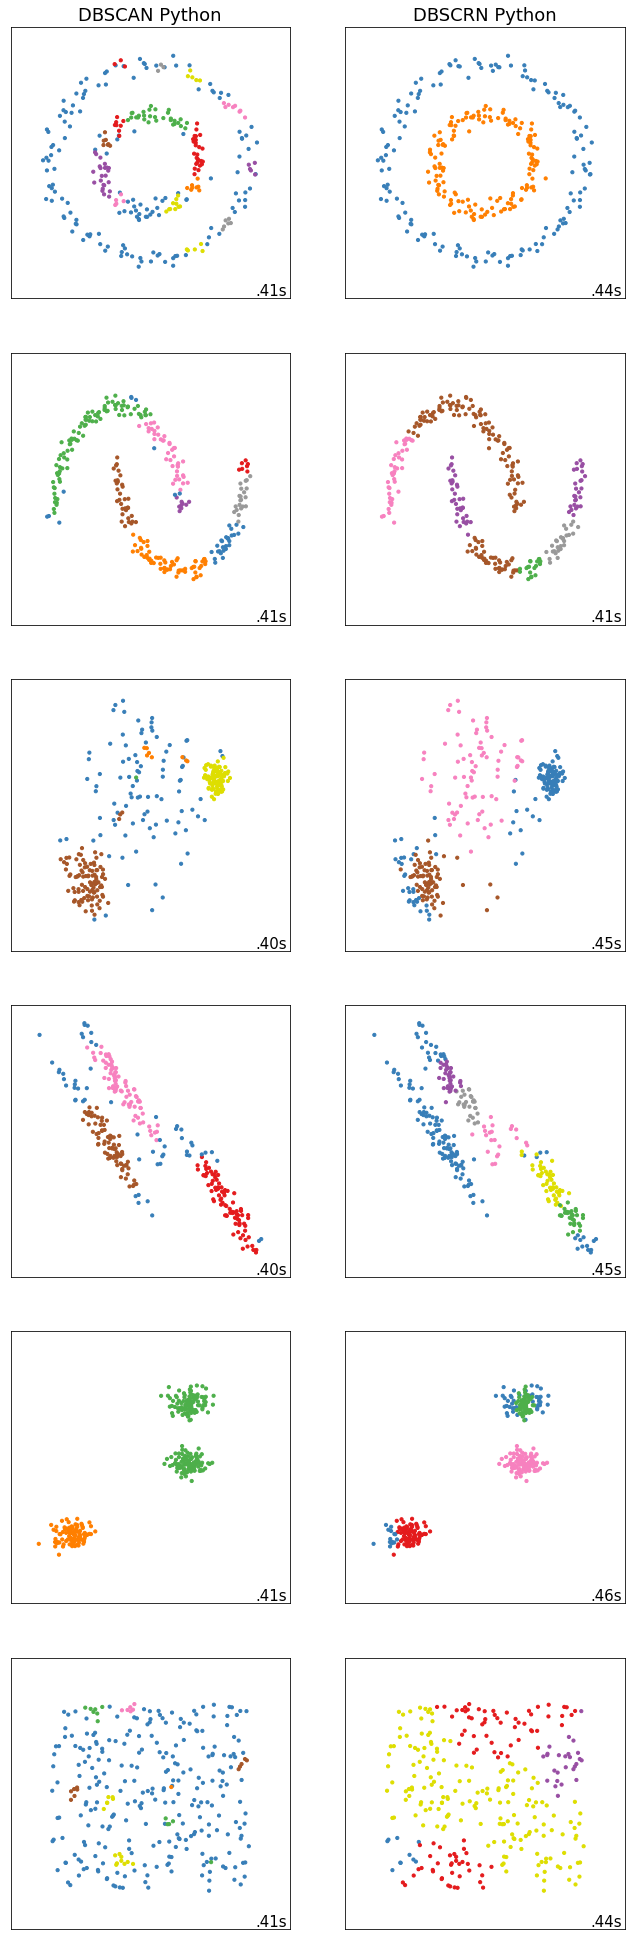

CPU times: user 5.47 s, sys: 0 ns, total: 5.47 s
Wall time: 5.43 s


In [44]:
%%time
plt.figure(figsize=(11, 35))

plot_num = 1

default_base = {
    "epsilon": 0.3,
    "minPts": 20,
    "k": 20
}

datasets = [
    (
        noisy_circles,
        {
            "epsilon": 0.15,
            "minPts": 5,
            "k": 30
        },
    ),
    (
        noisy_moons, 
        {
            "epsilon": 0.15,
            "minPts": 5,
            "k": 20
        }),
    (
        varied,
        {
            "epsilon": 0.15,
            "minPts": 5,
            "k": 20
        },
    ),
    (
        aniso,
        {
            "epsilon": 0.15,
            "minPts": 5,
            "k": 20
        },
    ),
    (
        blobs, 
        {            
            "epsilon": 0.65,
            "minPts": 20,
            "k": 20
        }
    ),
    (
        no_structure, 
     {
            "epsilon": 0.15,
            "minPts": 5,
            "k": 20
     }
    ),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    
    if algo_params:
        epsilon = algo_params['epsilon']
        minPts = algo_params['minPts']
        k = algo_params['k']
    else: 
        epsilon = default_base['epsilon']
        minPts = default_base['minPts']
        k = default_base['k']
        
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    clustering_algorithms = (
        ("DBSCAN Python", DBSCAN(epsilon, minPts)),
        ("DBSCRN Python", DBSCRN(k)),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        y_pred = algorithm.fit_transform(X)
        t1 = time.time()

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred.astype(int)])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()